In [64]:
import pandas as pd
import numpy as np
np.random.seed(8888)

import sklearn
import math

import gc

#library for evaluation metrics
from ml_metrics import rmsle #rmsle metric was defined by competition organizers 

#library for learning curves
from sklearn.model_selection import learning_curve

#libraries for cross validation 
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

#library for train and test dataset preparation
from sklearn.model_selection import train_test_split

#library for score function in learning curve drawing
from sklearn.metrics import make_scorer

#models
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


#libraries for feature importances
import eli5
from eli5.sklearn import PermutationImportance
from eli5 import show_prediction
from eli5.permutation_importance import get_score_importances

#library to visualize the development of the program in time
from tqdm import tqdm

#libraries for visualization
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(12,4)
import seaborn as sns

%matplotlib inline
pd.options.display.max_columns = 1_000 #so we can see more columns in dataframe 
pd.options.display.max_rows = 1_000 #like above, but for rows

In [36]:
#reading the training and test dataset
train = pd.read_hdf('diabetic_train.h5')
test = pd.read_hdf('diabetic_test.h5')

#concatenation of training and test dataset so that we can work on one dataframe
df_all = pd.concat([train, test])

#deletion of old dataframes which will not be used
del train, test

#cleaning the memory with gc
gc.collect()

40216

In [37]:
#first view on the dataframe, we have 66221 rows with 51 columns (features), "readmitted" is our target value
df_all.head(10)
#df_all.info()
#we have some integer and object values in the dataframe

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,id
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,0,0
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,0,2
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,True,True,0,3
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,True,True,0,4
8,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,68,2,28,0,0,0,398,427,38,8,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,True,True,0,8
11,36900,77391171,AfricanAmerican,Male,[60-70),?,2,1,4,7,?,?,62,0,11,0,0,0,157,288,197,7,None,None,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,True,True,100,11
12,40926,85504905,Caucasian,Female,[40-50),?,1,3,7,7,?,Family/GeneralPractice,60,0,15,0,1,0,428,250.43,250.6,8,None,None,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,True,True,100,12
17,84222,108662661,Caucasian,Female,[50-60),?,1,1,7,3,?,Cardiology,29,0,11,0,0,0,682,174,250,3,None,None,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,0,17
20,150006,22864131,?,Female,[50-60),?,2,1,4,2,?,?,66,1,19,0,0,0,410,427,428,7,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,True,True,0,20
22,182796,63000108,AfricanAmerican,Female,[70-80),?,2,1,4,2,?,?,47,0,12,0,0,0,410,401,582,8,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,0,22


In [38]:
#we can see some question marks on 'weight' column, probably this feature doesn't bring any value so we will delete it
df_all['weight'].value_counts(normalize=True)


?            0.974525
[75-100)     0.010163
[50-75)      0.007671
[100-125)    0.005029
[125-150)    0.001148
[25-50)      0.000831
[150-175)    0.000287
[0-25)       0.000257
[175-200)    0.000091
Name: weight, dtype: float64

In [39]:
#almost 97,5% of data in this column is missing so I decide to delete this column from dataframe
if 'weight' in df_all: del df_all['weight']
#df_all.head(10)

let's transform object values in categorical values that could be used by model

In [44]:
object_values = ['race', 'gender', 'age', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult' ]
for obj in object_values:
    print ('Normalized distribution of {0}:'.format(obj))
    print(df_all[obj].value_counts(normalize=True))
    print('______________________________________________________________________________')

Normalized distribution of race:
Caucasian          0.739569
AfricanAmerican    0.189910
?                  0.026200
Hispanic           0.021066
Other              0.016007
Asian              0.007248
Name: race, dtype: float64
______________________________________________________________________________
Normalized distribution of gender:
Female             0.531402
Male               0.468552
Unknown/Invalid    0.000045
Name: gender, dtype: float64
______________________________________________________________________________
Normalized distribution of age:
[70-80)     0.250570
[60-70)     0.220262
[50-60)     0.171230
[80-90)     0.165718
[40-50)     0.096752
[30-40)     0.039081
[90-100)    0.029975
[20-30)     0.017321
[10-20)     0.007052
[0-10)      0.002039
Name: age, dtype: float64
______________________________________________________________________________
Normalized distribution of payer_code:
?     0.399088
MC    0.308920
HM    0.059709
BC    0.050649
SP    0.047387
MD   

Name: diag_1, dtype: float64
______________________________________________________________________________
Normalized distribution of diag_2:
250       0.066308
276       0.065840
428       0.060132
427       0.048429
401       0.040788
599       0.032090
496       0.029658
414       0.026442
411       0.024811
403       0.023210
250.02    0.019858
707       0.017834
584       0.016415
585       0.015871
285       0.015358
250.01    0.015086
780       0.014572
518       0.014376
486       0.013546
682       0.012926
491       0.012791
425       0.012655
424       0.010359
413       0.010027
250.6     0.008230
493       0.008230
305       0.007188
786       0.006463
998       0.006237
280       0.005693
410       0.005557
785       0.005542
511       0.005361
38        0.004757
272       0.004696
197       0.004681
648       0.004576
162       0.004515
560       0.004364
996       0.004334
?         0.004289
997       0.004213
440       0.004138
295       0.004107
788       0.004092
V4

Name: diag_2, dtype: float64
______________________________________________________________________________
Normalized distribution of diag_3:
250       0.120641
401       0.087646
276       0.051102
428       0.040848
427       0.037012
414       0.034928
496       0.024252
272       0.021247
403       0.020688
599       0.018816
585       0.017170
?         0.016385
780       0.013123
250.02    0.012851
707       0.012549
V45       0.012519
285       0.011869
425       0.009997
305       0.009589
424       0.009408
250.6     0.009393
584       0.009227
518       0.008743
250.01    0.008472
682       0.007535
41        0.007128
278       0.007097
493       0.006418
530       0.005950
786       0.005648
244       0.005572
486       0.005572
491       0.005014
V58       0.004863
197       0.004425
785       0.004243
357       0.003926
511       0.003926
287       0.003851
411       0.003775
402       0.003624
250.4     0.003549
280       0.003549
412       0.003503
V15       0.003473
78

Name: diag_3, dtype: float64
______________________________________________________________________________
Normalized distribution of max_glu_serum:
None    0.948506
Norm    0.025853
>200    0.014421
>300    0.011220
Name: max_glu_serum, dtype: float64
______________________________________________________________________________
Normalized distribution of A1Cresult:
None    0.830598
>8      0.080262
Norm    0.051207
>7      0.037934
Name: A1Cresult, dtype: float64
______________________________________________________________________________


Race

In [46]:
df_race_features =pd.get_dummies(df_all['race'])
df_all = pd.concat([df_all, df_race_features], axis=1)

In [47]:
#Gender

In [48]:
df_all['gender_label']=df_all['gender'].map(lambda x: 1 if str(x)=='Female' else 0)

In [49]:
#Age

In [50]:
df_all['age'].unique()

array(['[0-10)', '[20-30)', '[30-40)', '[40-50)', '[80-90)', '[60-70)',
       '[50-60)', '[70-80)', '[10-20)', '[90-100)'], dtype=object)

In [51]:
age_ord_map = {'[0-10)': 1, '[10-20)': 2, '[20-30)': 3, 
               '[30-40)': 4, '[40-50)': 5, '[50-60)': 6,
              '[60-70)': 7, '[70-80)': 8, '[80-90)': 9, '[90-100)': 9}

df_all['age_label']=df_all['age'].map(age_ord_map)
df_all.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,id,?,AfricanAmerican,Asian,Caucasian,Hispanic,Other,gender_label,age_label
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,0,1,0,0,0,250.83,?,?,1,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,0,0,0,0,0,1,0,0,1,1
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,2,0,1,648,250,V27,6,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,0,2,0,1,0,0,0,0,1,3
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,True,True,0,3,0,0,0,1,0,0,0,4
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,0,8,0,0,0,197,157,250,5,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,True,True,0,4,0,0,0,1,0,0,0,5
8,12522,48330783,Caucasian,Female,[80-90),2,1,4,13,68,2,28,0,0,0,398,427,38,8,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,True,True,0,8,0,0,0,1,0,0,1,9


 Payer code and Medical specialty

In [53]:
if 'payer_code' in df_all: del df_all['payer_code']
if 'medical_specialty' in df_all: del df_all['medical_specialty']

In [54]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66221 entries, 0 to 101764
Data columns (total 56 columns):
encounter_id                66221 non-null int32
patient_nbr                 66221 non-null int32
race                        66221 non-null object
gender                      66221 non-null object
age                         66221 non-null object
admission_type_id           66221 non-null int8
discharge_disposition_id    66221 non-null int8
admission_source_id         66221 non-null int8
time_in_hospital            66221 non-null int8
num_lab_procedures          66221 non-null int16
num_procedures              66221 non-null int8
num_medications             66221 non-null int8
number_outpatient           66221 non-null int8
number_emergency            66221 non-null int8
number_inpatient            66221 non-null int8
diag_1                      66221 non-null object
diag_2                      66221 non-null object
diag_3                      66221 non-null object
number_diag

Diag_1, diag_2, diag_3

In [55]:
diags=['diag_1', 'diag_2', 'diag_3']
for diag in diags:
    df_all[diag+'_fact']=pd.factorize(df_all[diag])[0]

In [57]:
df_all.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,id,?,AfricanAmerican,Asian,Caucasian,Hispanic,Other,gender_label,age_label,diag_1_fact,diag_2_fact,diag_3_fact
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,0,1,0,0,0,250.83,?,?,1,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,0,0,0,0,0,1,0,0,1,1,0,0,0
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,2,0,1,648,250,V27,6,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,0,2,0,1,0,0,0,0,1,3,1,1,1
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,True,True,0,3,0,0,0,1,0,0,0,4,2,2,2
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,0,8,0,0,0,197,157,250,5,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,True,True,0,4,0,0,0,1,0,0,0,5,3,3,3
8,12522,48330783,Caucasian,Female,[80-90),2,1,4,13,68,2,28,0,0,0,398,427,38,8,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,True,True,0,8,0,0,0,1,0,0,1,9,4,4,4


Max glu serum

In [58]:
glu_ord_map = {'None': 1, 'Norm': 2, '>200': 3, 
               '>300': 4}

df_all['glu_serum_label']=df_all['max_glu_serum'].map(glu_ord_map)
df_all.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,id,?,AfricanAmerican,Asian,Caucasian,Hispanic,Other,gender_label,age_label,diag_1_fact,diag_2_fact,diag_3_fact,glu_serum_label
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,0,1,0,0,0,250.83,?,?,1,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,0,0,0,0,0,1,0,0,1,1,0,0,0,1
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,2,0,1,648,250,V27,6,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,0,2,0,1,0,0,0,0,1,3,1,1,1,1
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,True,True,0,3,0,0,0,1,0,0,0,4,2,2,2,1
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,0,8,0,0,0,197,157,250,5,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,True,True,0,4,0,0,0,1,0,0,0,5,3,3,3,1
8,12522,48330783,Caucasian,Female,[80-90),2,1,4,13,68,2,28,0,0,0,398,427,38,8,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,True,True,0,8,0,0,0,1,0,0,1,9,4,4,4,1


A1C result

In [59]:
A1C_ord_map = {'None': 1, 'Norm': 2, '>7': 3, 
               '>8': 4}

df_all['A1C_label']=df_all['A1Cresult'].map(A1C_ord_map)
df_all.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,id,?,AfricanAmerican,Asian,Caucasian,Hispanic,Other,gender_label,age_label,diag_1_fact,diag_2_fact,diag_3_fact,glu_serum_label,A1C_label
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,0,1,0,0,0,250.83,?,?,1,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,0,0,0,0,0,1,0,0,1,1,0,0,0,1,1
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,2,0,1,648,250,V27,6,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,0,2,0,1,0,0,0,0,1,3,1,1,1,1,1
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,True,True,0,3,0,0,0,1,0,0,0,4,2,2,2,1,1
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,0,8,0,0,0,197,157,250,5,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,True,True,0,4,0,0,0,1,0,0,0,5,3,3,3,1,1
8,12522,48330783,Caucasian,Female,[80-90),2,1,4,13,68,2,28,0,0,0,398,427,38,8,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,True,True,0,8,0,0,0,1,0,0,1,9,4,4,4,1,1


In [62]:
#training data preparation
#lets create a list of features that will be used and will not be used in the training dataset (blacklist)

feats = df_all.select_dtypes(include= np.number).columns #in feats we list only numerical
black_list = ['id', 'readmitted'] #id is just for kaggle competition, readmitted is target value
feats = [feat for feat in feats if feat not in black_list]

In [63]:
#training data
train = df_all[df_all['readmitted'] != ''].copy()
X_df = train[feats]
X_train = X_df.values
y_train = train['readmitted'].values.astype(np.int8)

In [65]:
#list of models
models = [
        xgb.XGBClassifier(random_state=8888,max_depth=7, n_estimators=300, objective='binary:logistic'),
        LogisticRegression(random_state=2019,solver='lbfgs'),
        DecisionTreeClassifier(random_state=2019),
        DecisionTreeRegressor(random_state=2019, max_depth=5),
        RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=10, min_samples_leaf=5,random_state=2019),
        ] 

In [66]:
#functions to perform first predictions with KFold and StratifiedKFold cross validation

def model_train_predict(X, y, model, folds=3, succes_metric=rmsle):
    cv = KFold(n_splits=folds, shuffle=True, random_state=2019)
    scores = []
    for train_idx, test_idx in cv.split(X):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        score = succes_metric(y[test_idx], y_pred)
        scores.append(score)
        print('rmsle=',score)
    return print('mean rmsle=', np.mean(scores), 'standard deviation (std)=' , np.std(scores))  

def model_train_predict2(X, y, model, folds=3, succes_metric=rmsle):
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=2019)
    scores = []
    for train_idx, test_idx in cv.split(X,y):
        X_fold_train, X_fold_test = X[train_idx], X[test_idx]
        y_fold_train, y_fold_test = y[train_idx], y[test_idx]
        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_test)
        score = succes_metric(y[test_idx], y_pred)
        scores.append(score)
        print('rmsle=',score)
    return print('mean rmsle=', np.mean(scores), 'standard deviation (std)=' , np.std(scores)) 

In [68]:
#Let's run all models and check the results

for i in range (0,len(models)):
    print ('Model: ', models[i])
    model = models[i]
    model_train_predict(X_train, y_train, model)
    print('______________________________________________________________________________')

Model:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=300, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=2019, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)
rmsle= 1.923
rmsle= 1.884
rmsle= 1.86
mean rmsle= 1.889 standard deviation (std)= 0.02579
______________________________________________________________________________
Model:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=2019, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
rmsle= 1.963
rmsle= 1.908
rmsle= 1.887
mean rmsle= 1.919 standard deviation (std)= 0.03207
____________________________

In [69]:
for i in range (0,len(models)):
    print ('Model: ', models[i])
    model = models[i]
    model_train_predict2(X_train, y_train, model)
    print('______________________________________________________________________________')

Model:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=300, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=2019, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)
rmsle= 1.885
rmsle= 1.876
rmsle= 1.888
mean rmsle= 1.883 standard deviation (std)= 0.00498
______________________________________________________________________________
Model:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=2019, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
rmsle= 1.919
rmsle= 1.919
rmsle= 1.919
mean rmsle= 1.919 standard deviation (std)= 0.0
_______________________________

Rough conclusion is that XGB model performs better than decision trees. StratifiedKFold gives a minimal better rmsle than simple KFold, therefore I'll use the StratifiedKFold for cross-validation

FEATURE ENGINEERING

In [70]:
# for feature importance I'll use ELI5 library
# let use XGB Classifier and see which feature is important

#first let's divide the data for two sets: train and test by train_test_split function
X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_train, y_train, shuffle=True, random_state=8888)

In [71]:
#XGBClassifier on training data, %time to check the time needed for model training
model = xgb.XGBClassifier(random_state=8888, max_depth=7, n_estimators=300, objective='binary:logistic')
%time model.fit(X_sub_train, y_sub_train)

Wall time: 54.5 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=300, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=888, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [72]:
#Let's check PermutationImportance on test data
#PermutationImportance checks features importance in such way that it mixes data in each feature column and then runs the model,
#if the model metric doesn't get worse by mixing of values it means that this feature may be random and is not significant

%time perm = PermutationImportance(model).fit(X_sub_test, y_sub_test)

Wall time: 1min 44s


In [73]:
#let's see most important 50 features by eli5
eli_show0=eli5.show_weights(perm, feature_names=feats, top=50)
eli_show0

#we have 4 features which look like significant for the model: number_inpatient, discharge_disposition_id, encounter_id, patient_nbr
#high significance of patient_nbr is some kind of surprise since according to description it's just unique patient id (???)

Weight,Feature
0.0183 ± 0.0030,number_inpatient
0.0068 ± 0.0013,discharge_disposition_id
0.0061 ± 0.0016,encounter_id
0.0057 ± 0.0036,patient_nbr
0.0030 ± 0.0009,number_emergency
0.0023 ± 0.0015,diag_3_fact
0.0015 ± 0.0007,number_outpatient
0.0015 ± 0.0014,num_procedures
0.0015 ± 0.0040,num_lab_procedures
0.0012 ± 0.0013,time_in_hospital


In [75]:
#let's check which features are important for RandomForestClassifier
X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_train, y_train, shuffle=True, random_state=8888)

In [76]:
model = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=10, min_samples_leaf=5,random_state=2019)
%time model.fit(X_sub_train, y_sub_train)

Wall time: 2.15 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=2019, verbose=0,
            warm_start=False)

In [77]:
%time perm = PermutationImportance(model).fit(X_sub_test, y_sub_test)

Wall time: 26.9 s


In [78]:
eli_show1=eli5.show_weights(perm, feature_names=feats, top=50)
eli_show1

Weight,Feature
0.0050 ± 0.0005,number_inpatient
0.0025 ± 0.0005,number_emergency
0.0008 ± 0.0005,number_outpatient
0.0004 ± 0.0006,discharge_disposition_id
0.0003 ± 0.0006,num_procedures
0.0003 ± 0.0002,Caucasian
0.0002 ± 0.0012,encounter_id
0.0001 ± 0.0008,insulin
0.0001 ± 0.0007,number_diagnoses
0.0001 ± 0.0002,metformin


In [79]:
#let's try to create some new features for those 4 features
#number inpatient
df_all["number_inpatien_count"] = df_all.groupby(["patient_nbr"])['number_inpatient'].transform('count')
df_all["number_inpatien_mean"] = df_all.groupby(["patient_nbr"])['number_inpatient'].transform('mean')
df_all["number_inpatien_min"] = df_all.groupby(["patient_nbr"])['number_inpatient'].transform('min')
df_all["number_inpatien_max"] = df_all.groupby(["patient_nbr"])['number_inpatient'].transform('max')
df_all["number_inpatien_sum"] = df_all.groupby(["patient_nbr"])['number_inpatient'].transform('sum')
df_all["number_inpatien_median"] = df_all.groupby(["patient_nbr"])['number_inpatient'].transform('median')

df_all["number_return_year"] =df_all["number_inpatien_max"] - df_all["number_inpatien_min"]


In [83]:
xgb.XGBClassifier(random_state=8888, max_depth=7, n_estimators=300, objective='binary:logistic')
X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_train, y_train, shuffle=True, random_state=8888)
model.fit(X_sub_train, y_sub_train)
perm = PermutationImportance(model).fit(X_sub_test, y_sub_test)
eli_show0=eli5.show_weights(perm, feature_names=feats, top=50)
eli_show0

Weight,Feature
0.0051 ± 0.0008,number_inpatient
0.0021 ± 0.0006,number_emergency
0.0006 ± 0.0006,number_outpatient
0.0005 ± 0.0004,age_label
0.0003 ± 0.0007,number_diagnoses
0.0003 ± 0.0010,encounter_id
0.0002 ± 0.0008,discharge_disposition_id
0.0002 ± 0.0002,AfricanAmerican
0.0002 ± 0.0001,glu_serum_label
0.0002 ± 0.0002,Caucasian


In [84]:
#encounter_id
#we can see that with increasing encounter_id number of diagnoses also increases
b=df_all[['number_diagnoses','encounter_id']].copy()
b.sort_values(by =['number_diagnoses','encounter_id'], inplace =True)
b

,number_diagnoses,encounter_id
66,1,715086
0,1,2278392
216,1,2735964
263,1,2948334
455,1,4065138
933,1,7178106
968,1,7331322
996,1,7500936
1004,1,7568742
1076,1,7976388


In [85]:
#therefore we can create for each patient new feature: difference between increasing encounter_id values
b=df_all[['patient_nbr','encounter_id']].copy()
b.sort_values(by =['patient_nbr','encounter_id'], inplace =True)
b['encounter_id_diff'] = b.groupby('patient_nbr')['encounter_id'].diff().fillna(0).astype("int64")
df_all = pd.merge(df_all, b,  how='left', on=('patient_nbr','encounter_id'))

In [86]:
#let's see the result for some patient_nbr
a=df_all[df_all["patient_nbr"]==103140]
a

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,id,?,AfricanAmerican,Asian,Caucasian,Hispanic,Other,gender_label,age_label,diag_1_fact,diag_2_fact,diag_3_fact,glu_serum_label,A1C_label,number_inpatien_count,number_inpatien_mean,number_inpatien_min,number_inpatien_max,number_inpatien_sum,number_inpatien_median,number_return_year,encounter_id_diff
5287,62439960,103140,AfricanAmerican,Female,[60-70),2,18,2,4,38,1,25,0,0,3,611,585,250.01,9,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,False,True,100,16735,0,1,0,0,0,0,1,7,173,155,34,1,1,9,5.888889,3,9,53.0,6.0,6,0
5350,62907468,103140,AfricanAmerican,Female,[60-70),1,18,7,2,46,2,13,0,0,4,789,707,295,9,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,100,16923,0,1,0,0,0,0,1,7,66,41,170,1,1,9,5.888889,3,9,53.0,6.0,6,467508
5607,64713408,103140,AfricanAmerican,Female,[60-70),1,18,7,2,42,1,16,1,0,5,786,250.41,581,9,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,False,True,100,17671,0,1,0,0,0,0,1,7,23,49,41,1,1,9,5.888889,3,9,53.0,6.0,6,966006
5675,65185692,103140,AfricanAmerican,Female,[60-70),1,18,7,4,50,4,24,1,0,6,410,403,250,4,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,100,17849,0,1,0,0,0,0,1,7,8,25,3,1,1,9,5.888889,3,9,53.0,6.0,6,472284
5821,66202086,103140,AfricanAmerican,Female,[60-70),1,18,7,3,43,1,21,1,0,7,404,518,250,3,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,100,18240,0,1,0,0,0,0,1,7,164,21,3,1,1,9,5.888889,3,9,53.0,6.0,6,1016394
6398,70600212,103140,AfricanAmerican,Female,[60-70),2,1,2,4,34,1,16,1,0,8,786,403,V45,9,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,False,True,100,19913,0,1,0,0,0,0,1,7,23,25,21,1,1,9,5.888889,3,9,53.0,6.0,6,2357100
8677,86281050,103140,AfricanAmerican,Female,[60-70),1,1,7,3,47,1,17,1,0,9,560,403,295,5,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,0,26083,0,1,0,0,0,0,1,7,34,25,170,1,1,9,5.888889,3,9,53.0,6.0,6,15680838
38518,63747402,103140,AfricanAmerican,Female,[60-70),1,18,7,4,43,2,11,1,0,4,560,250.01,585,7,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,,17253,0,1,0,0,0,0,1,7,34,15,96,1,1,9,5.888889,3,9,53.0,6.0,6,839934
39133,68243112,103140,AfricanAmerican,Female,[60-70),1,3,7,10,52,4,21,1,0,7,350,585,401,9,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,,19045,0,1,0,0,0,0,1,7,174,155,15,1,1,9,5.888889,3,9,53.0,6.0,6,2041026


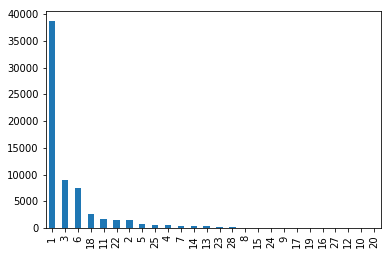

In [87]:
#discharge disposition_id
#lets check the diagram for this feature since numerical values doesn't tell much
df_all['discharge_disposition_id'].value_counts().plot(kind='bar');

In [89]:
#patient_nbr
#number of how many times each patient occurs in dataframe
df_all['number']=1
df_all["number_back"] = df_all.groupby(["patient_nbr"])['number'].transform('sum')
a=df_all[df_all["patient_nbr"]==103140]
#df_all.info()
#a

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66221 entries, 0 to 66220
Data columns (total 71 columns):
encounter_id                66221 non-null int32
patient_nbr                 66221 non-null int32
race                        66221 non-null object
gender                      66221 non-null object
age                         66221 non-null object
admission_type_id           66221 non-null int8
discharge_disposition_id    66221 non-null int8
admission_source_id         66221 non-null int8
time_in_hospital            66221 non-null int8
num_lab_procedures          66221 non-null int16
num_procedures              66221 non-null int8
num_medications             66221 non-null int8
number_outpatient           66221 non-null int8
number_emergency            66221 non-null int8
number_inpatient            66221 non-null int8
diag_1                      66221 non-null object
diag_2                      66221 non-null object
diag_3                      66221 non-null object
number_diagn

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,id,?,AfricanAmerican,Asian,Caucasian,Hispanic,Other,gender_label,age_label,diag_1_fact,diag_2_fact,diag_3_fact,glu_serum_label,A1C_label,number_inpatien_count,number_inpatien_mean,number_inpatien_min,number_inpatien_max,number_inpatien_sum,number_inpatien_median,number_return_year,encounter_id_diff,number,number_back
5287,62439960,103140,AfricanAmerican,Female,[60-70),2,18,2,4,38,1,25,0,0,3,611,585,250.01,9,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,False,True,100,16735,0,1,0,0,0,0,1,7,173,155,34,1,1,9,5.888889,3,9,53.0,6.0,6,0,1,9
5350,62907468,103140,AfricanAmerican,Female,[60-70),1,18,7,2,46,2,13,0,0,4,789,707,295,9,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,100,16923,0,1,0,0,0,0,1,7,66,41,170,1,1,9,5.888889,3,9,53.0,6.0,6,467508,1,9
5607,64713408,103140,AfricanAmerican,Female,[60-70),1,18,7,2,42,1,16,1,0,5,786,250.41,581,9,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,False,True,100,17671,0,1,0,0,0,0,1,7,23,49,41,1,1,9,5.888889,3,9,53.0,6.0,6,966006,1,9
5675,65185692,103140,AfricanAmerican,Female,[60-70),1,18,7,4,50,4,24,1,0,6,410,403,250,4,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,100,17849,0,1,0,0,0,0,1,7,8,25,3,1,1,9,5.888889,3,9,53.0,6.0,6,472284,1,9
5821,66202086,103140,AfricanAmerican,Female,[60-70),1,18,7,3,43,1,21,1,0,7,404,518,250,3,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,100,18240,0,1,0,0,0,0,1,7,164,21,3,1,1,9,5.888889,3,9,53.0,6.0,6,1016394,1,9
6398,70600212,103140,AfricanAmerican,Female,[60-70),2,1,2,4,34,1,16,1,0,8,786,403,V45,9,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,False,True,100,19913,0,1,0,0,0,0,1,7,23,25,21,1,1,9,5.888889,3,9,53.0,6.0,6,2357100,1,9
8677,86281050,103140,AfricanAmerican,Female,[60-70),1,1,7,3,47,1,17,1,0,9,560,403,295,5,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,0,26083,0,1,0,0,0,0,1,7,34,25,170,1,1,9,5.888889,3,9,53.0,6.0,6,15680838,1,9
38518,63747402,103140,AfricanAmerican,Female,[60-70),1,18,7,4,43,2,11,1,0,4,560,250.01,585,7,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,,17253,0,1,0,0,0,0,1,7,34,15,96,1,1,9,5.888889,3,9,53.0,6.0,6,839934,1,9
39133,68243112,103140,AfricanAmerican,Female,[60-70),1,3,7,10,52,4,21,1,0,7,350,585,401,9,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,,19045,0,1,0,0,0,0,1,7,174,155,15,1,1,9,5.888889,3,9,53.0,6.0,6,2041026,1,9


In [92]:
#new features with patient_nbr
columny1=["time_in_hospital","num_lab_procedures","num_procedures","num_medications" ]
for col in columny1:
    grouping1 = df_all.groupby(["patient_nbr"])[col]
    df_all[col+'_sum_all'] = grouping1.transform(sum).astype("int64")

columny2=["number_diagnoses","number_outpatient","number_emergency","number_inpatient","max_glu_serum_dic"]
for col in columny1:
    grouping1 = df_all.groupby(["patient_nbr"])[col]
    df_all[col+'_max'] = grouping1.transform(max).astype("int64")
   
    
columny3=["number_diagnoses"]
for col in columny1:
    grouping1 = df_all.groupby(["patient_nbr"])[col]
    df_all[col+'_min'] = grouping1.transform(min).astype("int64")
 

In [93]:
#some new features
#number of ambulatory and hospital visits
df_all["outpatient+inpatient"]=df_all[['number_outpatient','number_inpatient']].sum(axis=1)
df_all["number_emergency+inpatient"]=df_all[['number_emergency','number_inpatient']].sum(axis=1)

In [94]:
#Emergency_LabProcedures_Medications = number_emergency/(num_lab_procedures+num_medications)
df_all["Emergency_LabProcedures_Medications"]=df_all["number_emergency"]/(df_all["num_lab_procedures"]+df_all["num_medications"])
df_all[['number_emergency', 'num_lab_procedures','num_medications',"Emergency_LabProcedures_Medications"]].head(10)
df_all[['number_outpatient', 'number_inpatient',"outpatient+inpatient"]].head()

,number_outpatient,number_inpatient,outpatient+inpatient
0,0,0,0
1,2,1,3
2,0,0,0
3,0,0,0
4,0,0,0


In [95]:
#looking for interactions between features to make new features
import xgbfir
xgbfir.saveXgbFI(model,feature_names=feats, OutputXlsxFile='diabets.xlsx')
pd.read_excel('diabets.xlsx','Interaction Depth 2').head(15)

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,discharge_disposition_id|number_inpatient|numb...,11408.276363,33,8.181198,0.247915,345.705344,3863.982500,1,33,6,8,2,1,8.500000,7.363636,2.181818
1,number_emergency|number_inpatient|number_inpat...,6801.570647,28,4.670320,0.166797,242.913237,1030.027518,2,48,16,17,3,2,14.666667,13.392857,2.214286
2,number_inpatient|number_inpatient|number_inpat...,3369.126742,8,1.161099,0.145137,421.140843,384.362550,3,93,73,23,1,4,32.833333,7.375000,2.000000
3,encounter_id|patient_nbr|patient_nbr,2843.427506,188,20.675464,0.109976,15.124614,323.092625,4,1,3,34,48,5,15.833333,45.835106,4.872340
4,discharge_disposition_id|discharge_disposition...,2626.114167,71,9.576837,0.134885,36.987523,314.438528,5,11,5,24,19,6,11.666667,30.521127,4.070423
5,encounter_id|encounter_id|patient_nbr,2304.982789,142,10.821267,0.076206,16.232273,176.564005,6,2,4,50,44,15,20.166667,44.591549,5.140845
6,discharge_disposition_id|encounter_id|patient_nbr,2244.973993,103,3.716107,0.036079,21.795864,101.989352,7,4,23,76,31,25,27.666667,21.048544,5.281553
7,discharge_disposition_id|number_emergency|numb...,2208.908757,39,3.020556,0.077450,56.638686,197.579637,8,27,33,47,15,11,23.500000,9.589744,3.205128
8,discharge_disposition_id|number_diagnoses|numb...,2171.555442,18,6.874845,0.381936,120.641969,885.409192,9,71,8,2,5,3,16.333333,10.611111,2.555556
9,discharge_disposition_id|discharge_disposition...,2053.154739,28,5.508839,0.196744,73.326955,239.598423,10,49,11,14,11,9,17.333333,20.500000,3.214286


In [96]:
df_all['concat1']=df_all['number_back'] + df_all['number_inpatient'] 
df_all['concat2']=df_all['number_back'] * df_all['number_inpatient']
df_all['concat3']=df_all['number_back'] * df_all['num_lab_procedures_sum_all']

In [97]:
#let's check again the feature importance XGBClassifier feature importance
feats= df_all.select_dtypes(include=np.number).columns
black_list=['id', 'encounter_id', 'patient_nbr','readmitted']
feats=[feat for feat in feats if feat not in black_list]

train=df_all[df_all.readmitted !=''].copy()
X_df=train[feats]
X_train=X_df.values
y_train=train['readmitted'].values.astype(np.int8)

In [98]:
X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_train, y_train, shuffle=True, random_state=0)
model =xgb.XGBClassifier(random_state=8888,max_depth=7, n_estimators=300, objective='binary:logistic').fit(X_sub_train, y_sub_train)
model.fit(X_sub_test, y_sub_test)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=300, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=2019, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [99]:
perm = PermutationImportance(model).fit(X_sub_test, y_sub_test)
eli_show0=eli5.show_weights(perm, feature_names=feats, top=50)
eli_show0

Weight,Feature
0.1355 ± 0.0025,number_inpatien_count
0.0261 ± 0.0009,encounter_id_diff
0.0205 ± 0.0011,diag_1_fact
0.0187 ± 0.0007,diag_2_fact
0.0185 ± 0.0024,number_inpatient
0.0183 ± 0.0005,diag_3_fact
0.0144 ± 0.0012,discharge_disposition_id
0.0126 ± 0.0014,number_diagnoses
0.0109 ± 0.0016,admission_type_id
0.0099 ± 0.0012,age_label


In [111]:
model.feature_importances_

array([0.00710355, 0.00782854, 0.00670275, 0.00584309, 0.00644108,
       0.00654427, 0.00677806, 0.00600157, 0.0051152 , 0.02402973,
       0.00708109, 0.00530181, 0.00139002, 0.        , 0.        ,
       0.00594702, 0.        , 0.00589249, 0.0081191 , 0.        ,
       0.00638798, 0.00630877, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00593989, 0.00208687,
       0.        , 0.        , 0.        , 0.        , 0.00382504,
       0.00685697, 0.        , 0.00711063, 0.00516571, 0.0062634 ,
       0.00556495, 0.00629644, 0.006487  , 0.00618077, 0.00610485,
       0.00461071, 0.00609835, 0.5383826 , 0.01270448, 0.02699065,
       0.00946738, 0.01112337, 0.01603396, 0.00486464, 0.05633561,
       0.        , 0.        , 0.00460325, 0.00512731, 0.00516313,
       0.00621953, 0.00391569, 0.00544302, 0.00564314, 0.00582555,
       0.00559667, 0.00473989, 0.00555198, 0.00596036, 0.00898856,
       0.01213316, 0.00580989, 0.01332757, 0.0025599 , 0.01008

In [101]:
def draw_feature_importances(model, features):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 5))
    plt.title("Feature importances")
    plt.bar(range(X_train.shape[1]), model.feature_importances_[indices],
    color="b", align="center")
    plt.xticks(range(X_train.shape[1]), [ features[x] for x in indices])
    plt.xticks(rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

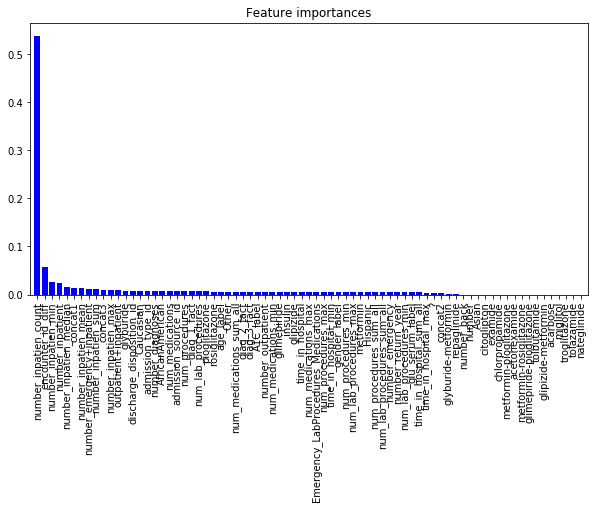

In [102]:
draw_feature_importances(model, feats)

In [115]:
#final model
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
best_feats = [ feats[x] for x in indices]
best_feats = best_feats[0:54]
best_feats

['number_inpatien_count',
 'encounter_id_diff',
 'number_inpatien_min',
 'number_inpatient',
 'number_inpatien_median',
 'concat1',
 'number_inpatien_mean',
 'number_emergency+inpatient',
 'number_inpatien_sum',
 'concat3',
 'number_inpatien_max',
 'outpatient+inpatient',
 'glyburide',
 'discharge_disposition_id',
 'Caucasian',
 'admission_type_id',
 'number_diagnoses',
 'AfricanAmerican',
 'num_medications',
 'admission_source_id',
 'num_procedures',
 'diag_1_fact',
 'num_lab_procedures',
 'pioglitazone',
 'rosiglitazone',
 'age_label',
 'Other',
 'num_medications_sum_all',
 'diag_2_fact',
 'diag_3_fact',
 'A1C_label',
 'number_outpatient',
 'num_medications_min',
 'glimepiride',
 'insulin',
 'glipizide',
 'time_in_hospital',
 'num_medications_max',
 'Emergency_LabProcedures_Medications',
 'num_procedures_max',
 'time_in_hospital_min',
 'gender_label',
 'num_procedures_min',
 'num_lab_procedures_max',
 'metformin',
 'Hispanic',
 'num_procedures_sum_all',
 'num_lab_procedures_sum_all',

In [116]:
train=df_all[df_all.readmitted !=''].copy()
X_df=train[best_feats]
X_train=X_df.values
y_train=train['readmitted'].values.astype(np.int8)

test = df_all[df_all.readmitted==''].copy()
# print( test.info() )
X_df_test=test[best_feats]
X_test=X_df_test.values

In [120]:
#final model: XGBClassifier
model = xgb.XGBClassifier(random_state=8888, max_depth=7, n_estimators=300, objective='binary:logistic')

In [121]:
KFold_split=50

In [122]:
model_train_predict2(X_train, y_train, model, folds=KFold_split)

rmsle= 1.354
rmsle= 1.091
rmsle= 1.162
rmsle= 1.28
rmsle= 1.202
rmsle= 1.162
rmsle= 1.317
rmsle= 1.365
rmsle= 1.202
rmsle= 1.354
rmsle= 1.202
rmsle= 1.242
rmsle= 1.216
rmsle= 1.242
rmsle= 1.255
rmsle= 1.12
rmsle= 1.354
rmsle= 1.242
rmsle= 1.389
rmsle= 1.176
rmsle= 1.148
rmsle= 1.281
rmsle= 1.318
rmsle= 1.217
rmsle= 1.243
rmsle= 1.204
rmsle= 1.281
rmsle= 1.19
rmsle= 1.318
rmsle= 1.163
rmsle= 1.282
rmsle= 1.218
rmsle= 1.191
rmsle= 1.205
rmsle= 1.344
rmsle= 1.391
rmsle= 1.205
rmsle= 1.231
rmsle= 1.27
rmsle= 1.257
rmsle= 1.149
rmsle= 1.205
rmsle= 1.27
rmsle= 1.149
rmsle= 1.295
rmsle= 1.332
rmsle= 1.344
rmsle= 1.344
rmsle= 1.107
rmsle= 1.295
mean rmsle= 1.247 standard deviation (std)= 0.0758


In [123]:
X_test=X_df_test.values
y_pred= model.predict(X_test)

In [124]:
test['readmitted']=y_pred
# print(y_pred)
test[ ['id','readmitted'] ].to_csv('../diabetes_final_without hyperopt.csv', index=False)

In [125]:
#plot learning curve
def plot_learning_curve(model, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
                    model, X, y, 
                    cv=cv, 
                    n_jobs=n_jobs, 
                    train_sizes=train_sizes, 
                    scoring=make_scorer(rmsle, greater_is_better=False)
                    )
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

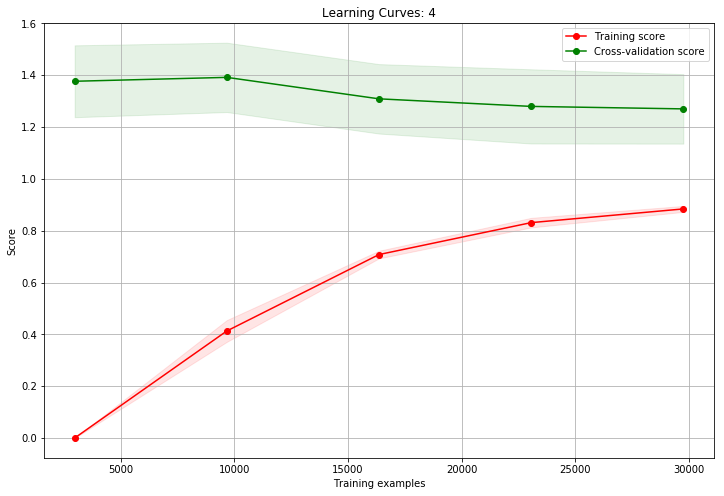

In [127]:
plt = plot_learning_curve(model,"Learning Curves: " + str(i).split('(')[0], X_train, y_train, cv=10, n_jobs=1)
plt.show()

In [131]:
pip install hyperopt

Note: you may need to restart the kernel to use updated packages.


HYPEROPT

In [132]:
from functools import partial
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

def objective(space):
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'random_state': int(space['random_state']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 100,
        'objective': 'reg:squarederror'
    }

    train=df_all[df_all.readmitted !=''].copy()
    X_df=train[best_feats]
    X_train=X_df.values
    y_train=train['readmitted'].values.astype(np.int8)

    test = df_all[df_all.readmitted==''].copy()
    # print( test.info() )
    X_df_test=test[best_feats]
    X_test=X_df_test.values

    model = xgb.XGBClassifier(**xgb_params)
    cv = StratifiedKFold(n_splits=5)

    scores = []
    for train_idx, test_idx in cv.split(X_train, y_train):
        X_fold_train, X_fold_test = X_train[train_idx], X_train[test_idx]
        y_fold_train, y_fold_test = y_train[train_idx], y_train[test_idx]

    
        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_test) 
    
        score = rmsle(y_fold_test, y_pred)
        scores.append( score )
    
    print("SCORE: {0}".format(score))
    
    return{'loss':score, 'status': STATUS_OK }

space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'random_state': hp.quniform ('x_random_state', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)


SCORE: 1.4912109375                                                                                                    
SCORE: 1.4931640625                                                                                                    
SCORE: 1.5                                                                                                             
SCORE: 1.48828125                                                                                                      
SCORE: 1.4765625                                                                                                       
SCORE: 1.4970703125                                                                                                    
SCORE: 1.4912109375                                                                                                    
SCORE: 1.4970703125                                                                                                    
SCORE: 1.4892578125                     